In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/MyDrive/energy updated dataset/day_ahead_energy_prices.xlsx'
# NY - CAAPITL

# PAPER FOR DATASETS: Unified Cross-REgional Time Series Day-Ahead Electricity Price Dataset

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel(file_path)

In [ ]:
df.head()

,Date,Price
0,2016-01-01 00:00:00,30.19
1,2016-01-01 01:00:00,25.35
2,2016-01-01 02:00:00,21.12
3,2016-01-01 03:00:00,21.07
4,2016-01-01 04:00:00,22.44


Epoch 1/50
1916/1916 [==============================] - 34s 15ms/step - loss: 4.6995e-04 - val_loss: 3.7438e-04
Epoch 2/50
1916/1916 [==============================] - 25s 13ms/step - loss: 2.2922e-04 - val_loss: 2.3707e-04
Epoch 3/50
1916/1916 [==============================] - 26s 14ms/step - loss: 1.8744e-04 - val_loss: 1.8651e-04
Epoch 4/50
1916/1916 [==============================] - 25s 13ms/step - loss: 1.7929e-04 - val_loss: 1.8194e-04
Epoch 5/50
1916/1916 [==============================] - 26s 13ms/step - loss: 1.6475e-04 - val_loss: 2.3560e-04
Epoch 6/50
1916/1916 [==============================] - 25s 13ms/step - loss: 1.6231e-04 - val_loss: 1.7405e-04
Epoch 7/50
1916/1916 [==============================] - 25s 13ms/step - loss: 1.6054e-04 - val_loss: 1.7712e-04
Epoch 8/50
1916/1916 [==============================] - 25s 13ms/step - loss: 1.5597e-04 - val_loss: 1.9439e-04
Epoch 9/50
1916/1916 [==============================] - 25s 13ms/step - loss: 1.5304e-04 - val_loss: 2.5

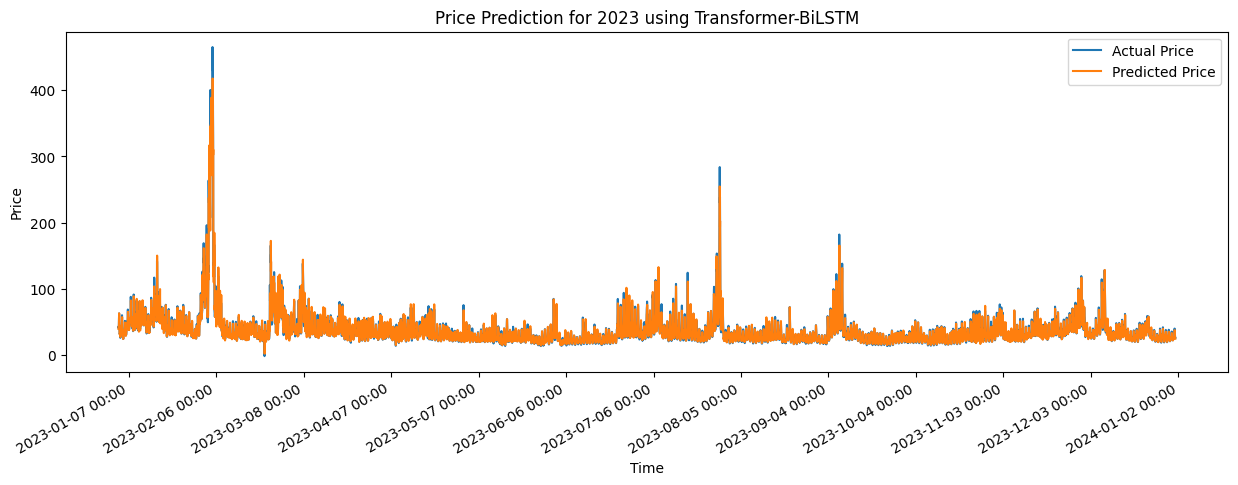

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df is your DataFrame containing 'Date' and 'Price'

# Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Creating a data structure with 60 timesteps and 1 output
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Splitting the data into training and testing sets based on the year
train_df = df[df.index.year <= 2022]
test_df = df[df.index.year == 2023]
train_scaled = scaler.transform(train_df['Price'].values.reshape(-1,1))
test_scaled = scaler.transform(test_df['Price'].values.reshape(-1,1))

X_train, y_train, X_test, y_test = [], [], [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
    y_test.append(test_scaled[i, 0])
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the positional_encoding and transformer_encoder functions
def positional_encoding(positions, d_model):
    angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads = np.arange(positions)[:, np.newaxis] * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model building function
def build_transformer_bilstm_model(input_shape, lstm_units=64, transformer_units=64, num_heads=4, ff_dim=64, mlp_units=[128], dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    x = inputs + positional_encoding(input_shape[0], input_shape[1])
    x = transformer_encoder(x, transformer_units, num_heads, ff_dim, dropout_rate)

    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)

    for units in mlp_units:
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Instantiate and train the model
model = build_transformer_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=64, transformer_units=64, num_heads=4, ff_dim=64, mlp_units=[128], dropout_rate=0.1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Predictions and Evaluation
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(test_actual, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_actual, predicted_prices)
r2 = r2_score(test_actual, predicted_prices)

def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)

smape = calculate_smape(test_actual, predicted_prices)

print(f"MAE: {mae}, RMSE: {rmse}, sMAPE: {smape}%, R^2: {r2}")

# Visualization
plt.figure(figsize=(15, 5))
plt.plot(test_df.index[-len(predicted_prices):], test_actual, label='Actual Price')
plt.plot(test_df.index[-len(predicted_prices):], predicted_prices, label='Predicted Price')
plt.title('Price Prediction for 2023 using Transformer-BiLSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

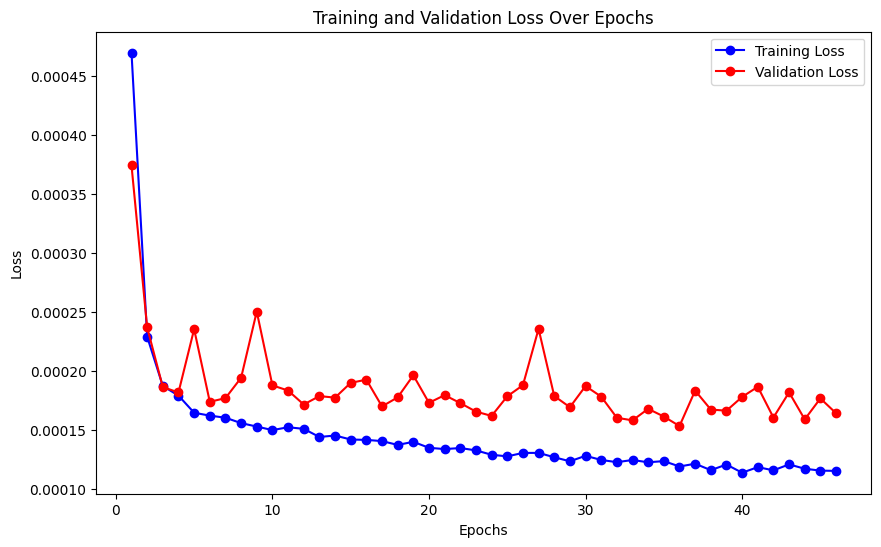

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


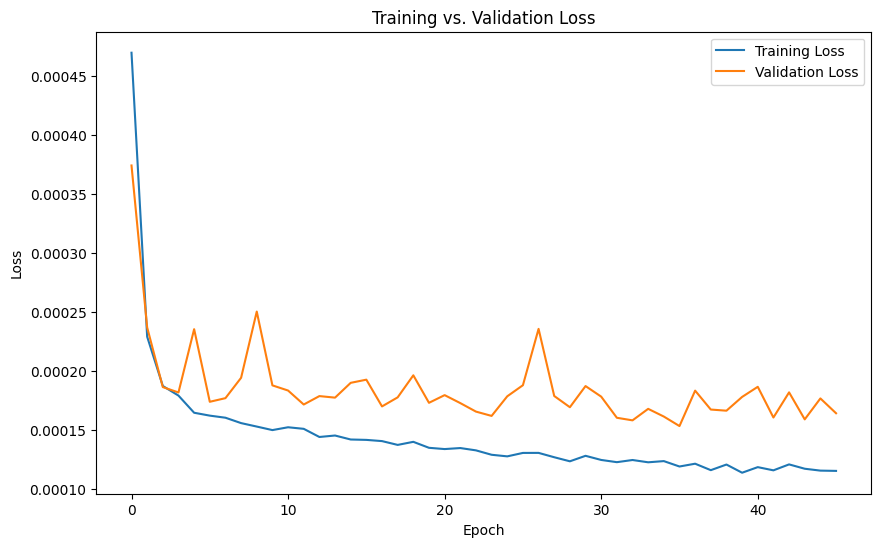

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


272/272 [==============================] - 1s 5ms/step


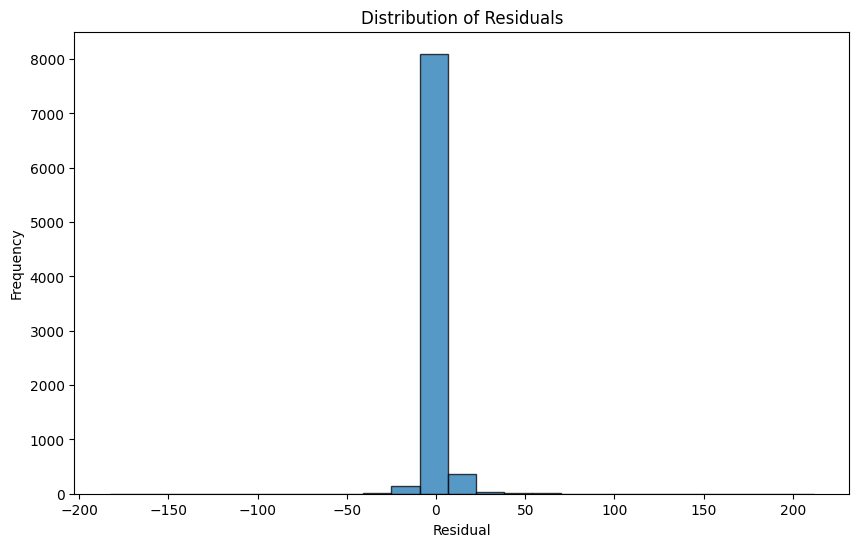

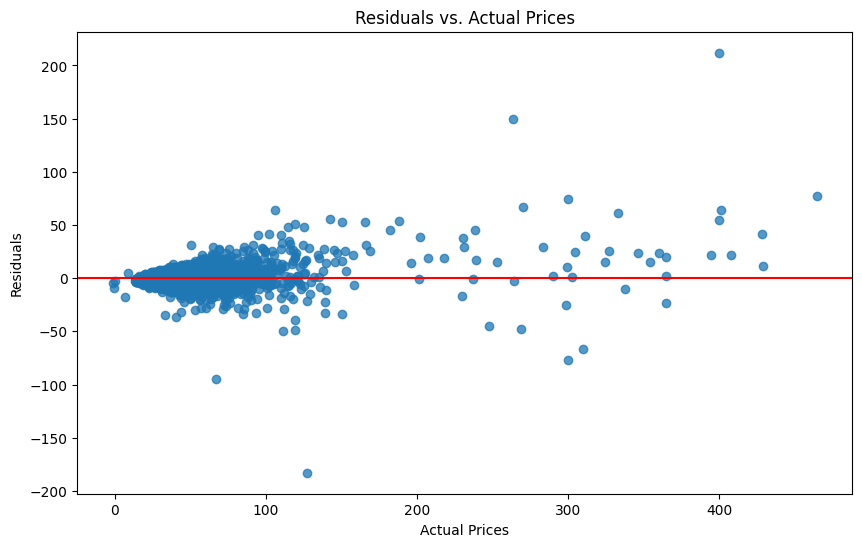

In [ ]:
# Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate residuals
residuals = test_actual - predicted_prices

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=25, alpha=0.75, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(x=test_actual, y=residuals, alpha=0.75)
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Actual Prices')
plt.show()


In [ ]:
# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame(predicted_prices, index=test_df.index[-len(predicted_prices):], columns=['Predicted'])

# Convert the index of the actual values to match the predicted values
actual_df = pd.DataFrame(test_actual, index=test_df.index[-len(predicted_prices):], columns=['Actual'])

# Combine actual and predicted values into a single DataFrame for comparison
comparison_df = pd.concat([actual_df, predicted_df], axis=1)

# Save the DataFrame to an Excel file
comparison_df.to_excel('best most updated 1 21 feb model_predictions_by_transformer-bilstm.xlsx')

print("Excel file created: model_predictions_by_transformer.xlsx")


Excel file created: model_predictions_by_transformer.xlsx


MAE: 2.725295676395811, RMSE: 4.465639867098898, sMAPE: 5.758659480913522%, R^2: 0.8596025569440198


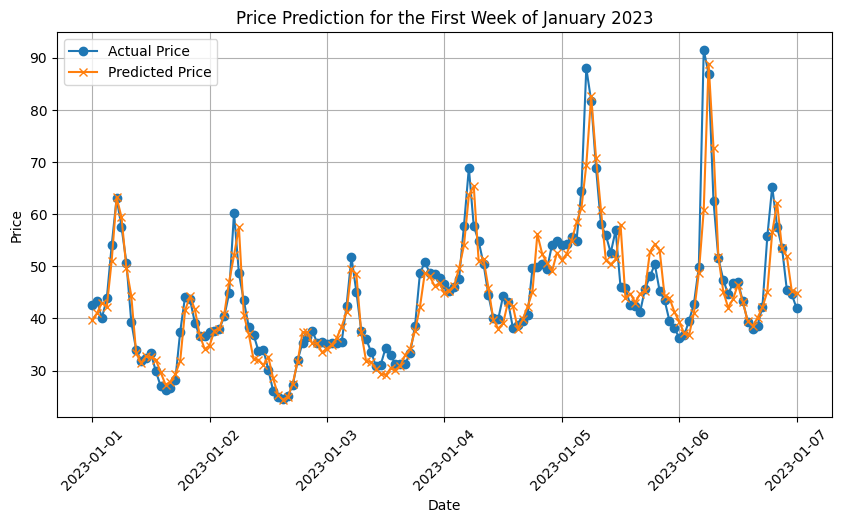

In [ ]:
# Identify the dates for the first week of January 2023
start_date = '2023-01-01'
end_date = '2023-01-07'

# Filter the test_df for the first week of January 2023
first_week_filter = (test_df.index >= start_date) & (test_df.index <= end_date)
first_week_dates = test_df.index[first_week_filter]

# Assuming test_df is indexed in the same order as X_test and y_test
# Find the indices in the predicted_prices and test_actual arrays that correspond to the first week
indices_first_week = np.where((test_df.index >= start_date) & (test_df.index <= end_date))[0]

# Slice the predicted_prices and test_actual arrays for the first week
predicted_prices_first_week = predicted_prices[indices_first_week]
test_actual_first_week = test_actual[indices_first_week]

# Calculate MAE
mae_week_of_interest = mean_absolute_error(test_actual_first_week, predicted_prices_first_week)

# Calculate RMSE
rmse_week_of_interest = np.sqrt(mean_squared_error(test_actual_first_week, predicted_prices_first_week))

# Calculate sMAPE
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)

smape_week_of_interest = calculate_smape(test_actual_first_week, predicted_prices_first_week)

# Calculate R2
r2_week_of_interest = r2_score(test_actual_first_week, predicted_prices_first_week)

print(f"MAE: {mae_week_of_interest}, RMSE: {rmse_week_of_interest}, sMAPE: {smape_week_of_interest}%, R^2: {r2_week_of_interest}")


# Visualization for the first week
plt.figure(figsize=(10, 5))
plt.plot(first_week_dates, test_actual_first_week, label='Actual Price', marker='o')
plt.plot(first_week_dates, predicted_prices_first_week, label='Predicted Price', marker='x')
plt.title('Price Prediction for the First Week of January 2023')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Best performing week starts on: 2023-12-31 with MAE: 0.9700283608613183
worst performing week starts on: 2023-02-05 with MAE: 18.12248273849487


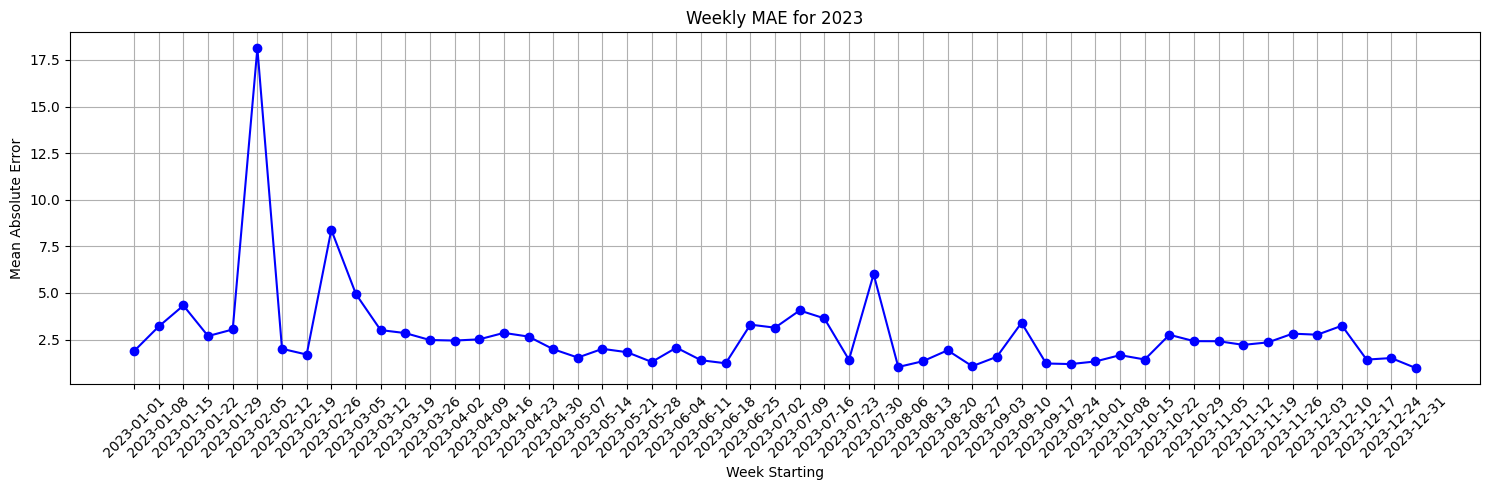

In [ ]:
# Initialize a list to store the performance of each week
weekly_performance = []

# Iterate over each week in the resampled DataFrame
for week_start, indices in test_df.resample('W').indices.items():
    if len(indices) == 0:
        continue  # Skip weeks without any data

    # Ensure the indices are within the bounds of the arrays
    valid_indices = [i for i in indices if i < len(predicted_prices)]

    # Extract the actual and predicted values for the week
    actual_week = test_actual[valid_indices]
    predicted_week = predicted_prices[valid_indices]

    # Calculate metrics for this week
    week_mae = mean_absolute_error(actual_week, predicted_week)
    weekly_performance.append((week_start, week_mae))

# Find the week with the best performance
best_week, best_week_mae = min(weekly_performance, key=lambda x: x[1])
worst_week, worst_week_mae = max(weekly_performance, key=lambda x: x[1])

# Print the best performing week
print(f"Best performing week starts on: {best_week.strftime('%Y-%m-%d')} with MAE: {best_week_mae}")
print(f"worst performing week starts on: {worst_week.strftime('%Y-%m-%d')} with MAE: {worst_week_mae}")


# For visualization
weeks = [wp[0] for wp in weekly_performance]
maes = [wp[1] for wp in weekly_performance]

plt.figure(figsize=(15, 5))
plt.plot(weeks, maes, marker='o', linestyle='-', color='b')
plt.title('Weekly MAE for 2023')
plt.xlabel('Week Starting')
plt.ylabel('Mean Absolute Error')
plt.xticks(weeks, rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


MAE: 1.2145161816827181, RMSE: 1.6794494267584765, sMAPE: 4.808600287386108%, R^2: 0.894028415286571


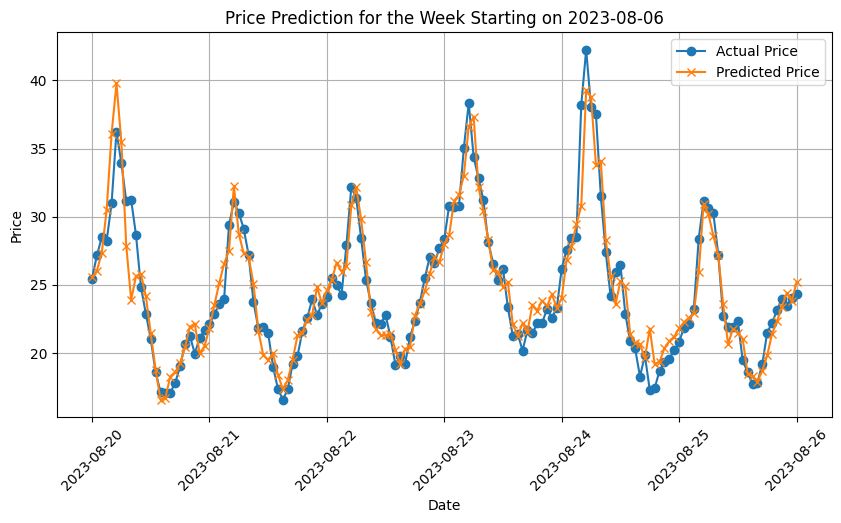

In [ ]:
# Identify the dates for the week starting on 2023-08-06
start_date = '2023-08-20'
end_date = '2023-08-26'

# Filter the test_df for the week of interest
week_of_interest_filter = (test_df.index >= start_date) & (test_df.index <= end_date)
week_of_interest_dates = test_df.index[week_of_interest_filter]

# Assuming test_df is indexed in the same order as X_test and y_test
# Find the indices in the predicted_prices and test_actual arrays that correspond to the week of interest
indices_week_of_interest = np.where((test_df.index >= start_date) & (test_df.index <= end_date))[0]

# Slice the predicted_prices and test_actual arrays for the week of interest
predicted_prices_week_of_interest = predicted_prices[indices_week_of_interest]
test_actual_week_of_interest = test_actual[indices_week_of_interest]

# Calculate MAE
mae_week_of_interest = mean_absolute_error(test_actual_week_of_interest, predicted_prices_week_of_interest)

# Calculate RMSE
rmse_week_of_interest = np.sqrt(mean_squared_error(test_actual_week_of_interest, predicted_prices_week_of_interest))

# Calculate sMAPE
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)

smape_week_of_interest = calculate_smape(test_actual_week_of_interest, predicted_prices_week_of_interest)

# Calculate R2
r2_week_of_interest = r2_score(test_actual_week_of_interest, predicted_prices_week_of_interest)

print(f"MAE: {mae_week_of_interest}, RMSE: {rmse_week_of_interest}, sMAPE: {smape_week_of_interest}%, R^2: {r2_week_of_interest}")



# Visualization for the week of interest
plt.figure(figsize=(10, 5))
plt.plot(week_of_interest_dates, test_actual_week_of_interest, label='Actual Price', marker='o')
plt.plot(week_of_interest_dates, predicted_prices_week_of_interest, label='Predicted Price', marker='x')
plt.title('Price Prediction for the Week Starting on 2023-08-06')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


MAE: 19.681462785391975, RMSE: 35.876982312632734, sMAPE: 12.754495259389763%, R^2: 0.8926143623835975


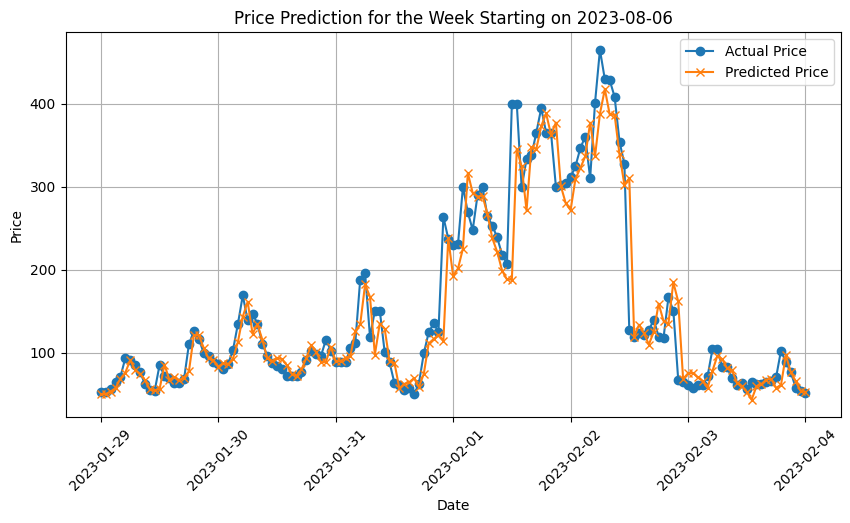

In [ ]:
# Identify the dates for the week starting on 2023-08-06
start_date = '2023-01-29'
end_date = '2023-02-04'

# Filter the test_df for the week of interest
week_of_interest_filter = (test_df.index >= start_date) & (test_df.index <= end_date)
week_of_interest_dates = test_df.index[week_of_interest_filter]

# Assuming test_df is indexed in the same order as X_test and y_test
# Find the indices in the predicted_prices and test_actual arrays that correspond to the week of interest
indices_week_of_interest = np.where((test_df.index >= start_date) & (test_df.index <= end_date))[0]

# Slice the predicted_prices and test_actual arrays for the week of interest
predicted_prices_week_of_interest = predicted_prices[indices_week_of_interest]
test_actual_week_of_interest = test_actual[indices_week_of_interest]

# Calculate MAE
mae_week_of_interest = mean_absolute_error(test_actual_week_of_interest, predicted_prices_week_of_interest)

# Calculate RMSE
rmse_week_of_interest = np.sqrt(mean_squared_error(test_actual_week_of_interest, predicted_prices_week_of_interest))

# Calculate sMAPE
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)

smape_week_of_interest = calculate_smape(test_actual_week_of_interest, predicted_prices_week_of_interest)

# Calculate R2
r2_week_of_interest = r2_score(test_actual_week_of_interest, predicted_prices_week_of_interest)

print(f"MAE: {mae_week_of_interest}, RMSE: {rmse_week_of_interest}, sMAPE: {smape_week_of_interest}%, R^2: {r2_week_of_interest}")


# Visualization for the week of interest
plt.figure(figsize=(10, 5))
plt.plot(week_of_interest_dates, test_actual_week_of_interest, label='Actual Price', marker='o')
plt.plot(week_of_interest_dates, predicted_prices_week_of_interest, label='Predicted Price', marker='x')
plt.title('Price Prediction for the Week Starting on 2023-08-06')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
